In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import src.constants as con
from src.data_loader import DataLoader
from src.stepdetect import LRTStepChangeDetector
from src.reactor_volume import BioreactorVolumeCalculator
from src.utils import (
    combine_online_and_offline_data,
    sort_time_data,
    calculate_time_intervals,
)

%load_ext autoreload
%autoreload 2

### Load the data and create the results direcotry

In [2]:
data_dir = Path("data")
data_path = data_dir / r"measurements.xlsx"

results_path = Path("results")
if not results_path.exists():
    results_path.mkdir()

experiment = 1
log_dir = results_path / f"experiment_{experiment:02}"
if not log_dir.exists():
    log_dir.mkdir(parents=True)

### Create a DataLoader object and load the data

In [3]:
loader = DataLoader(path=data_path)
online_df = loader.load_addition_data(sheet_name="cumulative_additions")
samples_df = loader.load_sample_data(sheet_name="samples")

In [4]:
time = np.array(online_df["time_h"])
offline_samples = np.array(samples_df)
feeding_data = np.array(online_df.drop(columns=["time_h"]))
feeding_data.shape

(500, 5)

### Track the working volume

A step change detection algorithm (in this case the liklehood ratio test) is used to identify the moment when an amount of nutrient/reagent is added to the bioreactor. This information is then used to track the change of the working volume over time

In [5]:
step_detector = LRTStepChangeDetector(delta=con.DELTA, min_size=con.MIN_SIZE)
addition_indices = step_detector.apply_to_streams(feeding_data)

In [6]:
calculator = BioreactorVolumeCalculator(
    initial_volume=con.V_INIT, F_in=con.F_IN, F_out=con.F_OUT
)
online_feedings = calculator.calculate_stream_volume(
    time, feeding_data, addition_indices
)

In [7]:
combined_data = combine_online_and_offline_data(online_feedings, offline_samples)
sorted_material_addition_matrix = sort_time_data(combined_data)

In [8]:
sampling_intervals = calculate_time_intervals(time)
working_volume = calculator.calculate_volume(
    time=time,
    sampling_intervals=sampling_intervals,
    material_addition_matrix=sorted_material_addition_matrix,
)

### Plot the working volume over time

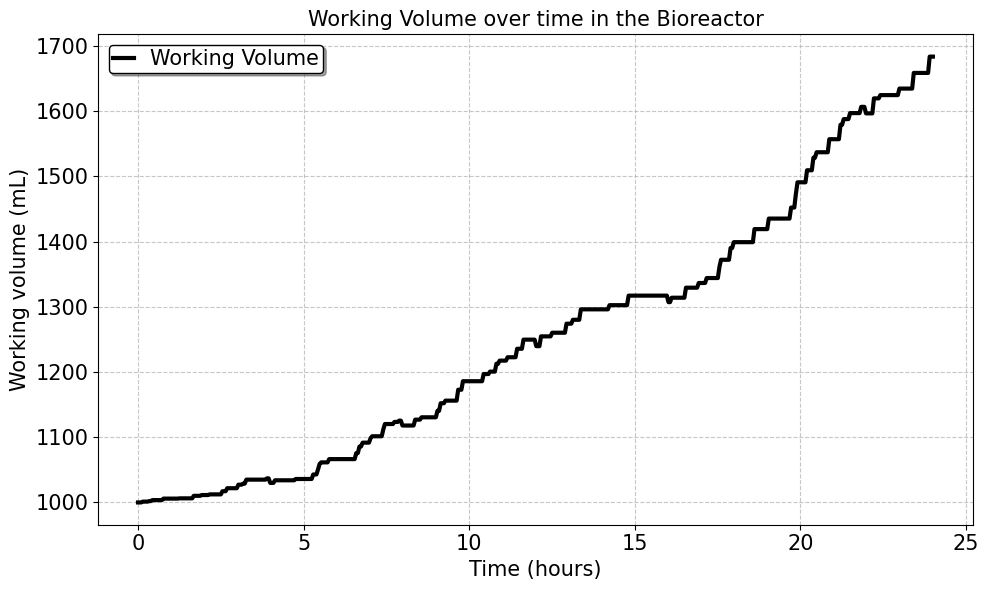

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(time, working_volume, linestyle="-", lw=3, color="k", label="Working Volume")
plt.title("Working Volume over time in the Bioreactor", fontsize=15)
plt.xlabel("Time (hours)", fontsize=15)
plt.ylabel("Working volume (mL)", fontsize=15)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(
    prop={"size": 15},
    fontsize=12,
    frameon=True,
    framealpha=1.0,
    edgecolor="k",
    borderpad=0.2,
    handlelength=1,
    shadow=True,
)
plt.tight_layout()
plt.show()

### Export the results   

In [10]:
results = np.vstack((time, working_volume)).T
results.shape

(500, 2)

In [23]:
np.savetxt(
    log_dir / "working_volume.csv",
    results,
    header="Time(h), Volume(mL)",
    delimiter=",",
    fmt="%f",
)